In [15]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 2500.0
bigT = 40000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570486533  X= 26.36213272426545
A2=  -0.49962370647516496  X= 40.0
A2=  -0.5019378672698831  X= 26.85173370346741
A2=  -0.5018381151222431  X= 21.703563407126815
A2=  -0.501873065422044  X= 15.347950695901392
A2=  -0.5019294650803621  X= 13.257546515093031
A2=  -0.5019294650803621  X= 13.257546515093031
MU= 0.31816194102760903 MASS= 0.09999058237901089


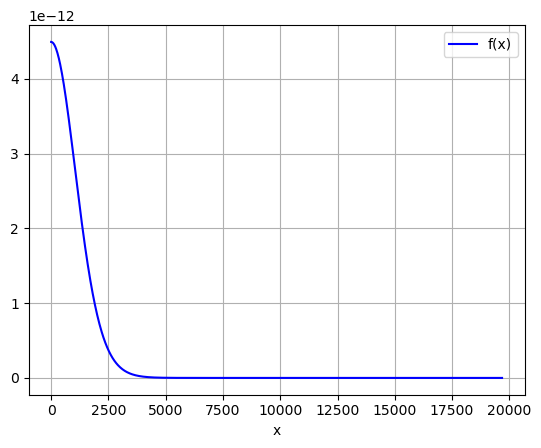

(1000,)


In [16]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [17]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [18]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DT:", dt)
print("DX:", dx)

[5.83965913e-02+0.j 5.83562444e-02+0.j 5.82756467e-02+0.j
 5.81549904e-02+0.j 5.79945626e-02+0.j 5.77947442e-02+0.j
 5.75560086e-02+0.j 5.72789191e-02+0.j 5.69641270e-02+0.j
 5.66123687e-02+0.j 5.62244627e-02+0.j 5.58013062e-02+0.j
 5.53438713e-02+0.j 5.48532009e-02+0.j 5.43304047e-02+0.j
 5.37766546e-02+0.j 5.31931797e-02+0.j 5.25812617e-02+0.j
 5.19422297e-02+0.j 5.12774548e-02+0.j 5.05883449e-02+0.j
 4.98763395e-02+0.j 4.91429037e-02+0.j 4.83895234e-02+0.j
 4.76176993e-02+0.j 4.68289418e-02+0.j 4.60247656e-02+0.j
 4.52066844e-02+0.j 4.43762059e-02+0.j 4.35348270e-02+0.j
 4.26840289e-02+0.j 4.18252726e-02+0.j 4.09599947e-02+0.j
 4.00896031e-02+0.j 3.92154737e-02+0.j 3.83389462e-02+0.j
 3.74613217e-02+0.j 3.65838590e-02+0.j 3.57077727e-02+0.j
 3.48342301e-02+0.j 3.39643500e-02+0.j 3.30992004e-02+0.j
 3.22397975e-02+0.j 3.13871042e-02+0.j 3.05420299e-02+0.j
 2.97054292e-02+0.j 2.88781023e-02+0.j 2.80607947e-02+0.j
 2.72541974e-02+0.j 2.64589474e-02+0.j 2.56756287e-02+0.j
 2.49047725e-0

In [19]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [20]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = -1.0
            T[i][i+1] = 1.0
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0
            if i>2:
                TSph[i][i+1] = 1.0/2.0/x[i]
                TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)*np.absolute(psi)
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.05851169532858928 1.0001208262730128
1 0.08351027137908527 0.058798785602179264 1.0001158385427054
2 0.16702054275817055 0.05904846679417635 1.0001107738829154
3 0.2505308141372558 0.05925455425608591 1.0001066435706036
4 0.3340410855163411 0.05942106456246042 1.000103479522259
5 0.4175513568954264 0.0594944457316316 1.0001015982608072
6 0.5010616282745116 0.05955770851074425 1.0001005710940825
7 0.5845718996535969 0.05955923138066537 1.0001001763714863
8 0.6680821710326822 0.05956293604939526 1.0001002043193525
9 0.7515924424117675 0.05955467002160014 1.0001002513963069
10 0.8351027137908528 0.05954471259021191 1.0001003707191518
11 0.9186129851699381 0.059554533195910433 1.000100251857077
12 1.0021232565490232 0.05955659063973432 1.000100036232149
13 1.0856335279281086 0.05958543792711308 1.0000995907566526
14 1.1691437993071938 0.05960557449401822 1.0000990229598041
15 1.2526540706862792 0.05964490278474131 1.0000983176763307
16 1.3361643420653644 0.05967874751431682 1.00009

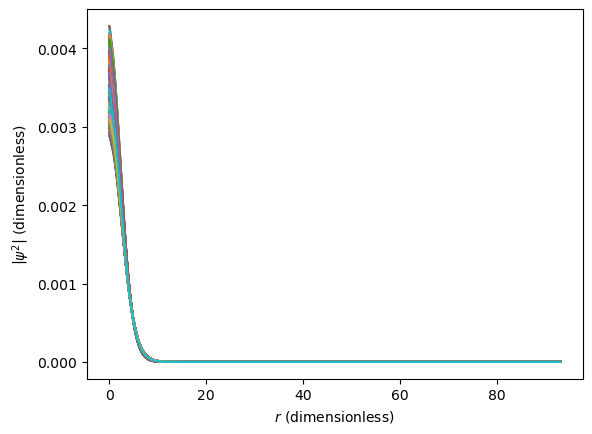

In [21]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

hello = []
hello2 = []
ts = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(t*dt<6.0):
        GM = newGM
    if(t*dt>=6.0):
        GM = oldGM

    setupT()
    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
    #if(normalization >= 1.01):
    #    break
    print(t, t*dt, np.absolute(psi[0]), normalization)
    if(GM == oldGM):

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*x[:i]*x[:i]*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello2.append(findMass())

        hello.append(np.absolute(psi[0])*np.absolute(psi[0]))
        ts.append(t*dt)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

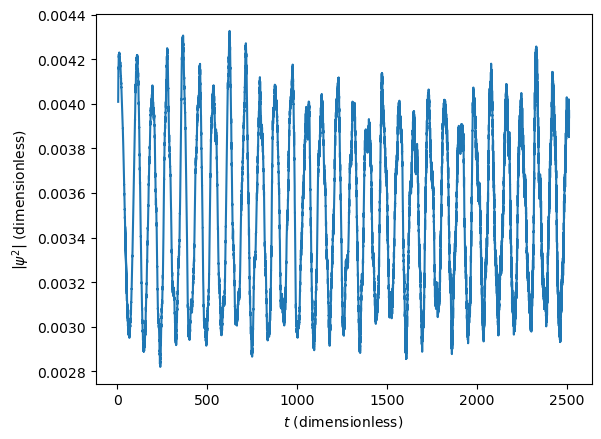

In [29]:
plt.plot(ts[:30000], hello[:30000])
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

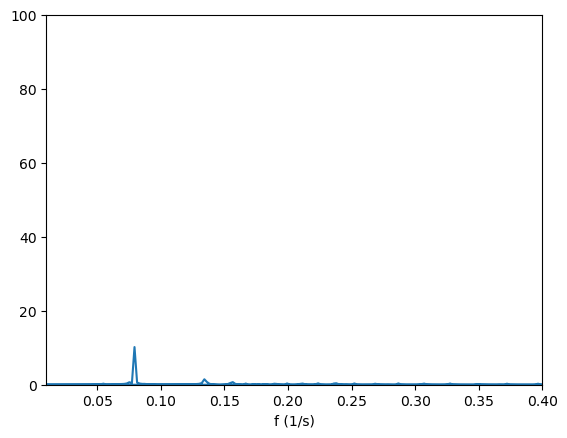

In [23]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100.0)
plt.xlabel("f (1/s)")

In [24]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.002033830895612102
0.014236816269284714 0.059301031931654584
0.020338308956121022 0.07438404132919668
0.026439801642957325 0.06882861596534358
0.034575125225405734 0.07300291308369927
0.046778110599078354 0.09693686581736113
0.05491343418152675 0.28619373117386565
0.07525174313764778 0.6694508704620511
0.07931940492887198 10.19152804878595
0.0874547285113204 0.22597742381302874
0.09965771388499299 0.07957140189874948
0.13423283911039874 1.4758525403652616
0.15660497896213185 0.703782997745939
0.16677413344019235 0.31726241842889125
0.17287562612702867 0.18353613493406654
0.1769432879182529 0.12194840373055672
0.1830447806050892 0.17728895535423408
0.18914627329192552 0.2712094616619595
0.19931542776998598 0.34658459450395296
0.2115184131436586 0.3102663742047778
0.22372139851733122 0.37404146294002916
0.23795821478661597 0.3937473383207562
0.24609353836906434 0.07392512162960135
0.25219503105590063 0.3503222362084861
0.2684656782207975 0.27168096415020837
0.27863483269885797 0.048370

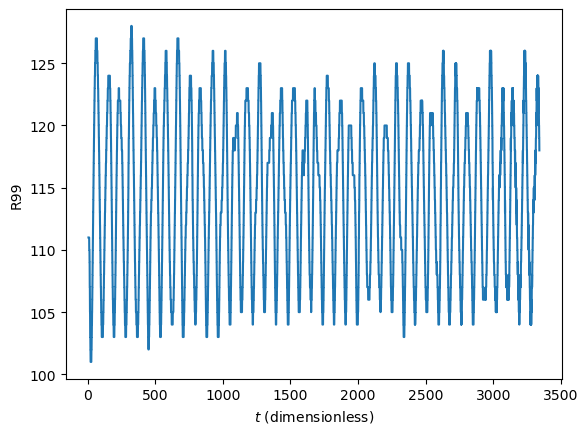

In [25]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

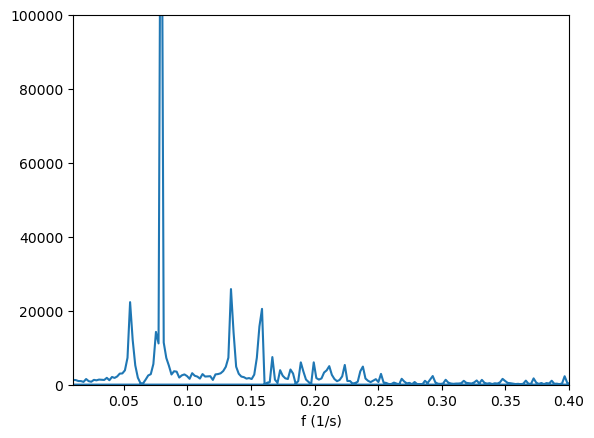

In [26]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [27]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.002033830895612102
0.05491343418152675 22341.977237766925
0.07525174313764778 14284.441107469118
0.07931940492887198 181522.03550640246
0.13423283911039874 25877.59435478824
0.15863880985774395 20523.058468694282
0.16677413344019235 7482.022570646589
0.18914627329192552 6051.789372716163
0.19931542776998598 6050.855299782568
0.2115184131436586 5026.442989975295
0.22372139851733122 5352.412768500893


[5.92480265e-02 5.90845624e-02 5.86855806e-02 5.80063480e-02
 5.76693814e-02 5.72791827e-02 5.71168730e-02 5.68489968e-02
 5.67084218e-02 5.63401517e-02 5.60531471e-02 5.55259140e-02
 5.50968122e-02 5.44776310e-02 5.39894401e-02 5.33298807e-02
 5.27887423e-02 5.21093395e-02 5.15393751e-02 5.08321340e-02
 5.02440044e-02 4.95284161e-02 4.88910573e-02 4.81172316e-02
 4.73980091e-02 4.65710651e-02 4.58002764e-02 4.49583423e-02
 4.41689052e-02 4.33164748e-02 4.25043384e-02 4.16651933e-02
 4.08368287e-02 3.99685659e-02 3.90893034e-02 3.82059817e-02
 3.73308319e-02 3.64581098e-02 3.55862327e-02 3.47513935e-02
 3.38887196e-02 3.30623303e-02 3.22056935e-02 3.13934002e-02
 3.05318555e-02 2.97231137e-02 2.88680638e-02 2.80711498e-02
 2.72177161e-02 2.64427191e-02 2.56273731e-02 2.48942928e-02
 2.41204453e-02 2.34224411e-02 2.26725687e-02 2.19971702e-02
 2.12588048e-02 2.05947785e-02 1.98821696e-02 1.92526902e-02
 1.85868872e-02 1.79944591e-02 1.73591494e-02 1.67850503e-02
 1.61693776e-02 1.562091

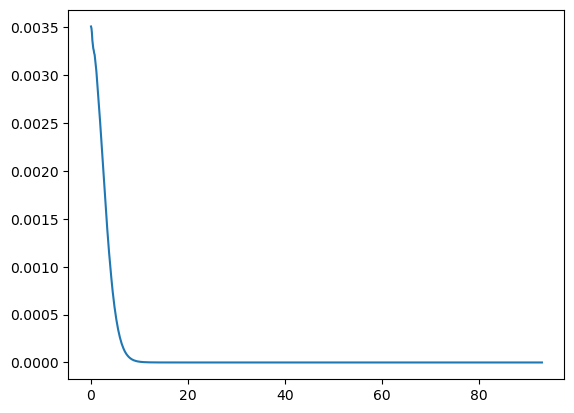

In [28]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?